# Tensorflow Lite Object Detection


For details on training tensorflow object detection API for mobilenet, converting to tflite model, ref [tensorflow-object-detection-api.md](https://github.com/mangalbhaskar/codehub/blob/master/readme/tensorflow-object-detection-api.md)

In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display

import cv2

/codehub/virtualmachines/virtualenvs/py_3-6-8_2020-01-23/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/codehub/virtualmachines/virtualenvs/py_3-6-8_2020-01-23/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/codehub/virtualmachines/virtualenvs/py_3-6-8_2020-01-23/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint

In [13]:
## Import the tensorflow object detection module
print(sys.path)
sys.path.append('/codehub/external/tensorflow/models/research')

['/codehub/scripts/tf/py', '/codehub/external/py-faster-rcnn/caffe-fast-rcnn/python', '/codehub/virtualmachines/virtualenvs/py_3-6-8_2020-01-23/lib/python36.zip', '/codehub/virtualmachines/virtualenvs/py_3-6-8_2020-01-23/lib/python3.6', '/codehub/virtualmachines/virtualenvs/py_3-6-8_2020-01-23/lib/python3.6/lib-dynload', '/usr/lib/python3.6', '', '/codehub/virtualmachines/virtualenvs/py_3-6-8_2020-01-23/lib/python3.6/site-packages', '/codehub/virtualmachines/virtualenvs/py_3-6-8_2020-01-23/lib/python3.6/site-packages/IPython/extensions', '/home/alpha/.ipython', '/codehub/external/tensorflow/models/research', '/codehub/external/tensorflow/models/research']


In [15]:
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

## Patches:
## patch tf1 into `utils.ops`
#utils_ops.tf = tf.compat.v1
## Patch the location of gfile
#tf.gfile = tf.io.gfile

## Path configurations

In [16]:
TFLITE_MODEL_FILEPATH = "/aimldl-dat/logs/tf_ods/ssd_mobilenet_v2_annon-280220_172500/TFLite_model/290220_163433/tflite_graph.tflite"
TFLITE_LABELMAP_FILEPATH = "/aimldl-dat/logs/tf_ods/ssd_mobilenet_v2_annon-280220_172500/TFLite_model/290220_163433/train-labelmap.txt"
TEST_IMG_DIR = "/aimldl-dat/samples/Trafic_Signs/images-mini"

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [35]:
## Load the label map
with open(TFLITE_LABELMAP_FILEPATH, 'r') as f:
    labels = [line.strip() for line in f.readlines()]
    category_index = {i:{'name':item} for i,item in enumerate(labels)}

In [36]:
category_index

{0: {'name': 'traffic_sign'}}

## Loading Model
TFLite Interpreter is used to load the tflite model file

In [20]:
# from tflite_runtime.interpreter import Interpreter
from tensorflow.lite.python.interpreter import Interpreter

interpreter = Interpreter(model_path=TFLITE_MODEL_FILEPATH)
interpreter.allocate_tensors()

# Detection

Run the inference on the single image

In [22]:
def run_inference_for_single_image(model, image):
#     image = np.asarray(image)
#     ## The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
#     input_tensor = tf.convert_to_tensor(image)
#     ## The model expects a batch of images, so add an axis with `tf.newaxis`.
#     input_tensor = input_tensor[tf.newaxis,...]

    ## Get model details
    input_details = model.get_input_details()
    output_details = model.get_output_details()
    height = input_details[0]['shape'][1]
    width = input_details[0]['shape'][2]

    input_mean = 127.5
    input_std = 127.5

    ## Load image and resize to expected shape [1xHxWx3]
    imH, imW, _ = image.shape 
    image_resized = cv2.resize(image, (width, height))
    input_data = np.expand_dims(image_resized, axis=0)

    floating_model = (input_details[0]['dtype'] == np.float32)
    ## Normalize pixel values if using a floating model (i.e. if model is non-quantized)
    if floating_model:
        input_data = (np.float32(input_data) - input_mean) / input_std

    ## Run inference
    ## Perform the actual detection by running the model with the image as input
    model.set_tensor(input_details[0]['index'], input_data)
    model.invoke()

    ## Retrieve detection results
    detection_boxes = model.get_tensor(output_details[0]['index'])[0] # Bounding box coordinates of detected objects
    detection_classes = model.get_tensor(output_details[1]['index'])[0] # Class index of detected objects
    scores = model.get_tensor(output_details[2]['index'])[0] # Confidence of detected objects
    num_detections = model.get_tensor(output_details[3]['index'])[0]  # Total number of detected objects (inaccurate and not needed)

    output_dict = {
        'num_detections': num_detections
        ,'detection_classes': detection_classes.astype(np.int64)
        ,'detection_boxes': detection_boxes
        ,'detection_scores': scores
        ,'width': imW
        ,'height': imH
    }

    return output_dict

In [23]:
vis_util.visualize_boxes_and_labels_on_image_array?

In [51]:
def show_inference_with_tfod(output_dict, image_np):
    ## Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=0.3,
      line_thickness=8)

    display(Image.fromarray(image_np))


def show_inference_with_cv2(output_dict, image):
    scores = output_dict['detection_scores']
    boxes = output_dict['detection_boxes']
    classes = output_dict['detection_classes']
    imH, imW = output_dict['height'], output_dict['width']
    
    threshold = 0.3
    min_conf_threshold = float(threshold)
    # Loop over all detections and draw detection box if confidence is above minimum threshold
    for i in range(len(scores)):
        if ((scores[i] > min_conf_threshold) and (scores[i] <= 1.0)):

            # Get bounding box coordinates and draw box
            # Interpreter can return coordinates that are outside of image dimensions, need to force them to be within image using max() and min()
            ymin = int(max(1,(boxes[i][0] * imH)))
            xmin = int(max(1,(boxes[i][1] * imW)))
            ymax = int(min(imH,(boxes[i][2] * imH)))
            xmax = int(min(imW,(boxes[i][3] * imW)))
            
            cv2.rectangle(image, (xmin,ymin), (xmax,ymax), (10, 255, 0), 2)

            # Draw label
            object_name = labels[int(classes[i])] # Look up object name from "labels" array using class index
            label = '%s: %d%%' % (object_name, int(scores[i]*100)) # Example: 'person: 72%'
            labelSize, baseLine = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2) # Get font size
            label_ymin = max(ymin, labelSize[1] + 10) # Make sure not to draw label too close to top of window
            cv2.rectangle(image, (xmin, label_ymin-labelSize[1]-10), (xmin+labelSize[0], label_ymin+baseLine-10), (255, 255, 255), cv2.FILLED) # Draw white box to put label text in
            cv2.putText(image, label, (xmin, label_ymin-7), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2) # Draw label text

    # All the results have been drawn on the image, now display the image
    cv2.imshow('Object detector', image)


def show_inference(model, image_path):
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
#     image_np = np.array(Image.open(image_path))

    image = cv2.imread(image_path)
    image_np = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    ## Actual detection
    output_dict = run_inference_for_single_image(model, image_np)

    show_inference_with_tfod(output_dict, image_np)
    show_inference_with_cv2(output_dict, image)


Run it on each test image and show the results:

In [52]:
import pathlib

PATH_TO_TEST_IMAGES_DIR = pathlib.Path(TEST_IMG_DIR)
TEST_IMAGE_PATHS = sorted(list(PATH_TO_TEST_IMAGES_DIR.glob("*.jpg")))
TEST_IMAGE_PATHS

[PosixPath('/aimldl-dat/samples/Trafic_Signs/images-mini/100818_135420_16716_zed_l_032.jpg'),
 PosixPath('/aimldl-dat/samples/Trafic_Signs/images-mini/100818_135420_16716_zed_l_098.jpg')]

/aimldl-dat/samples/Trafic_Signs/images-mini/100818_135420_16716_zed_l_032.jpg


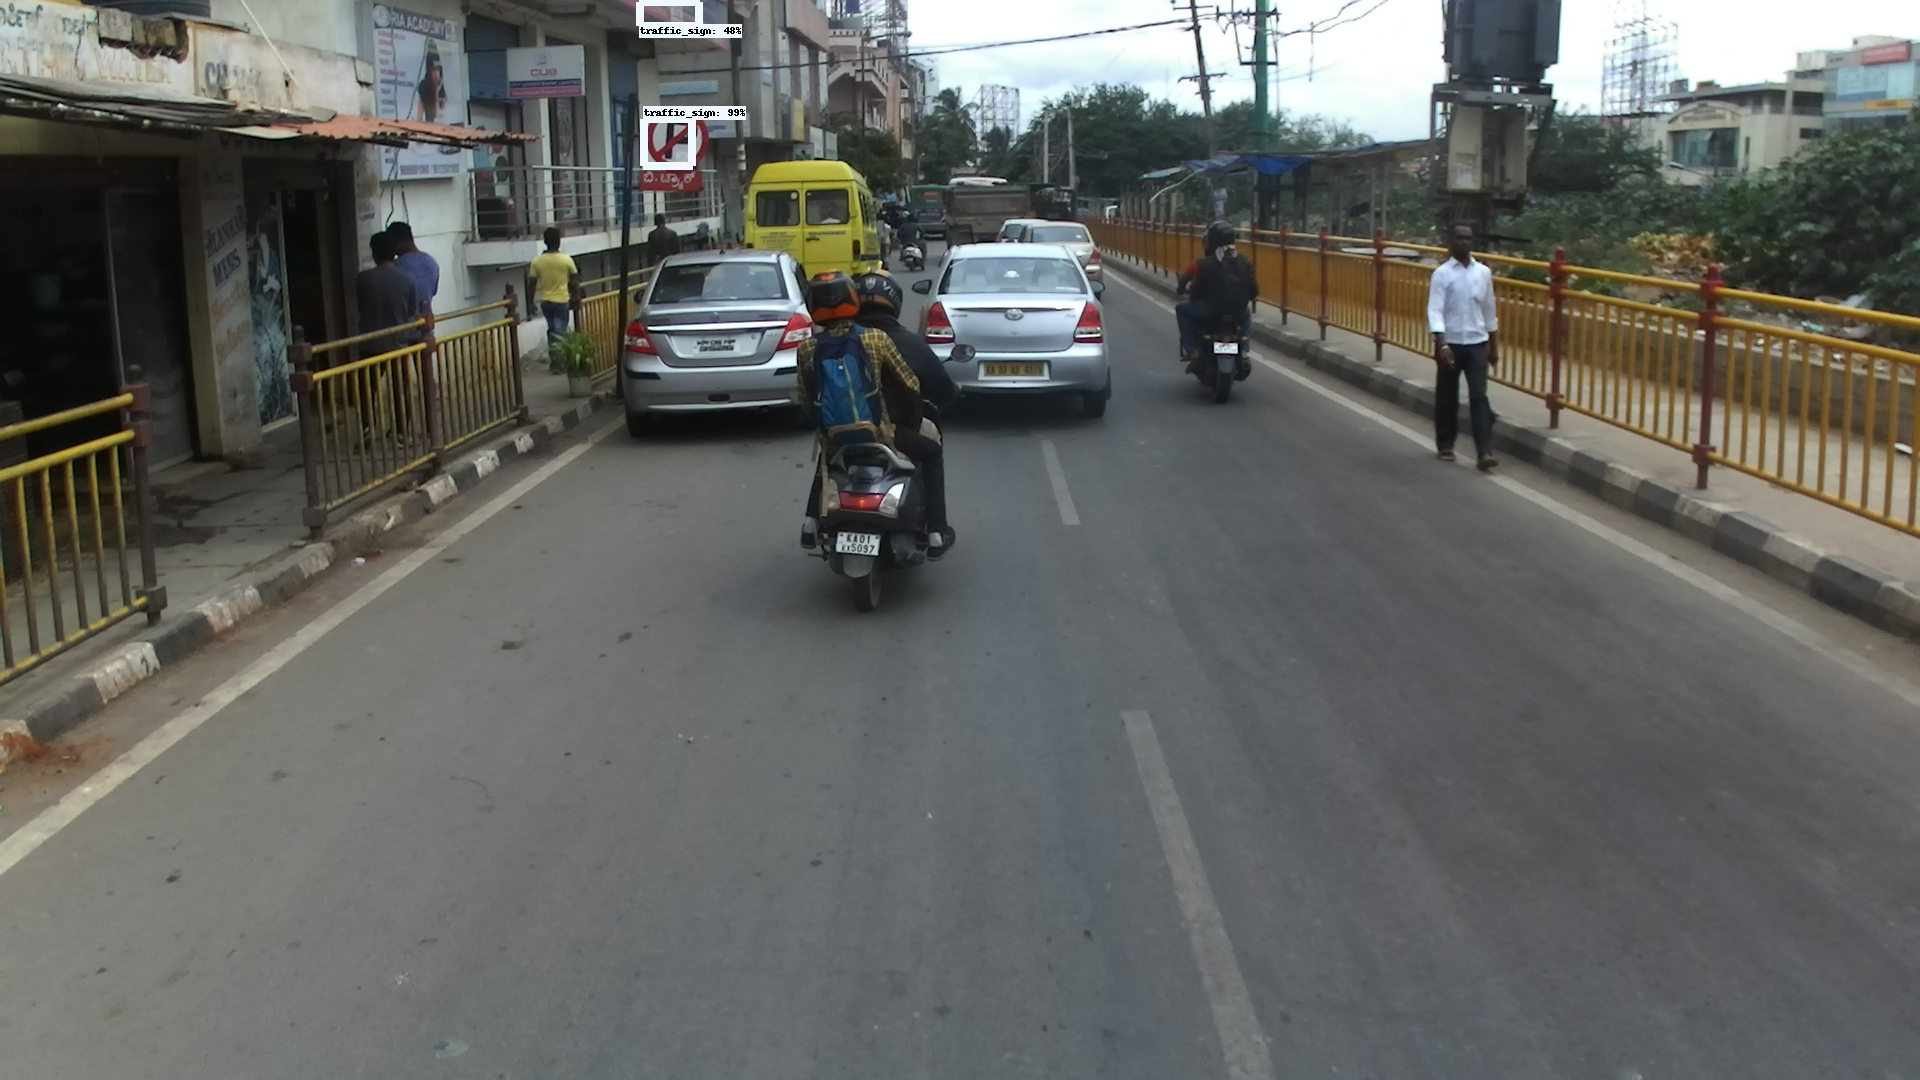

/aimldl-dat/samples/Trafic_Signs/images-mini/100818_135420_16716_zed_l_098.jpg


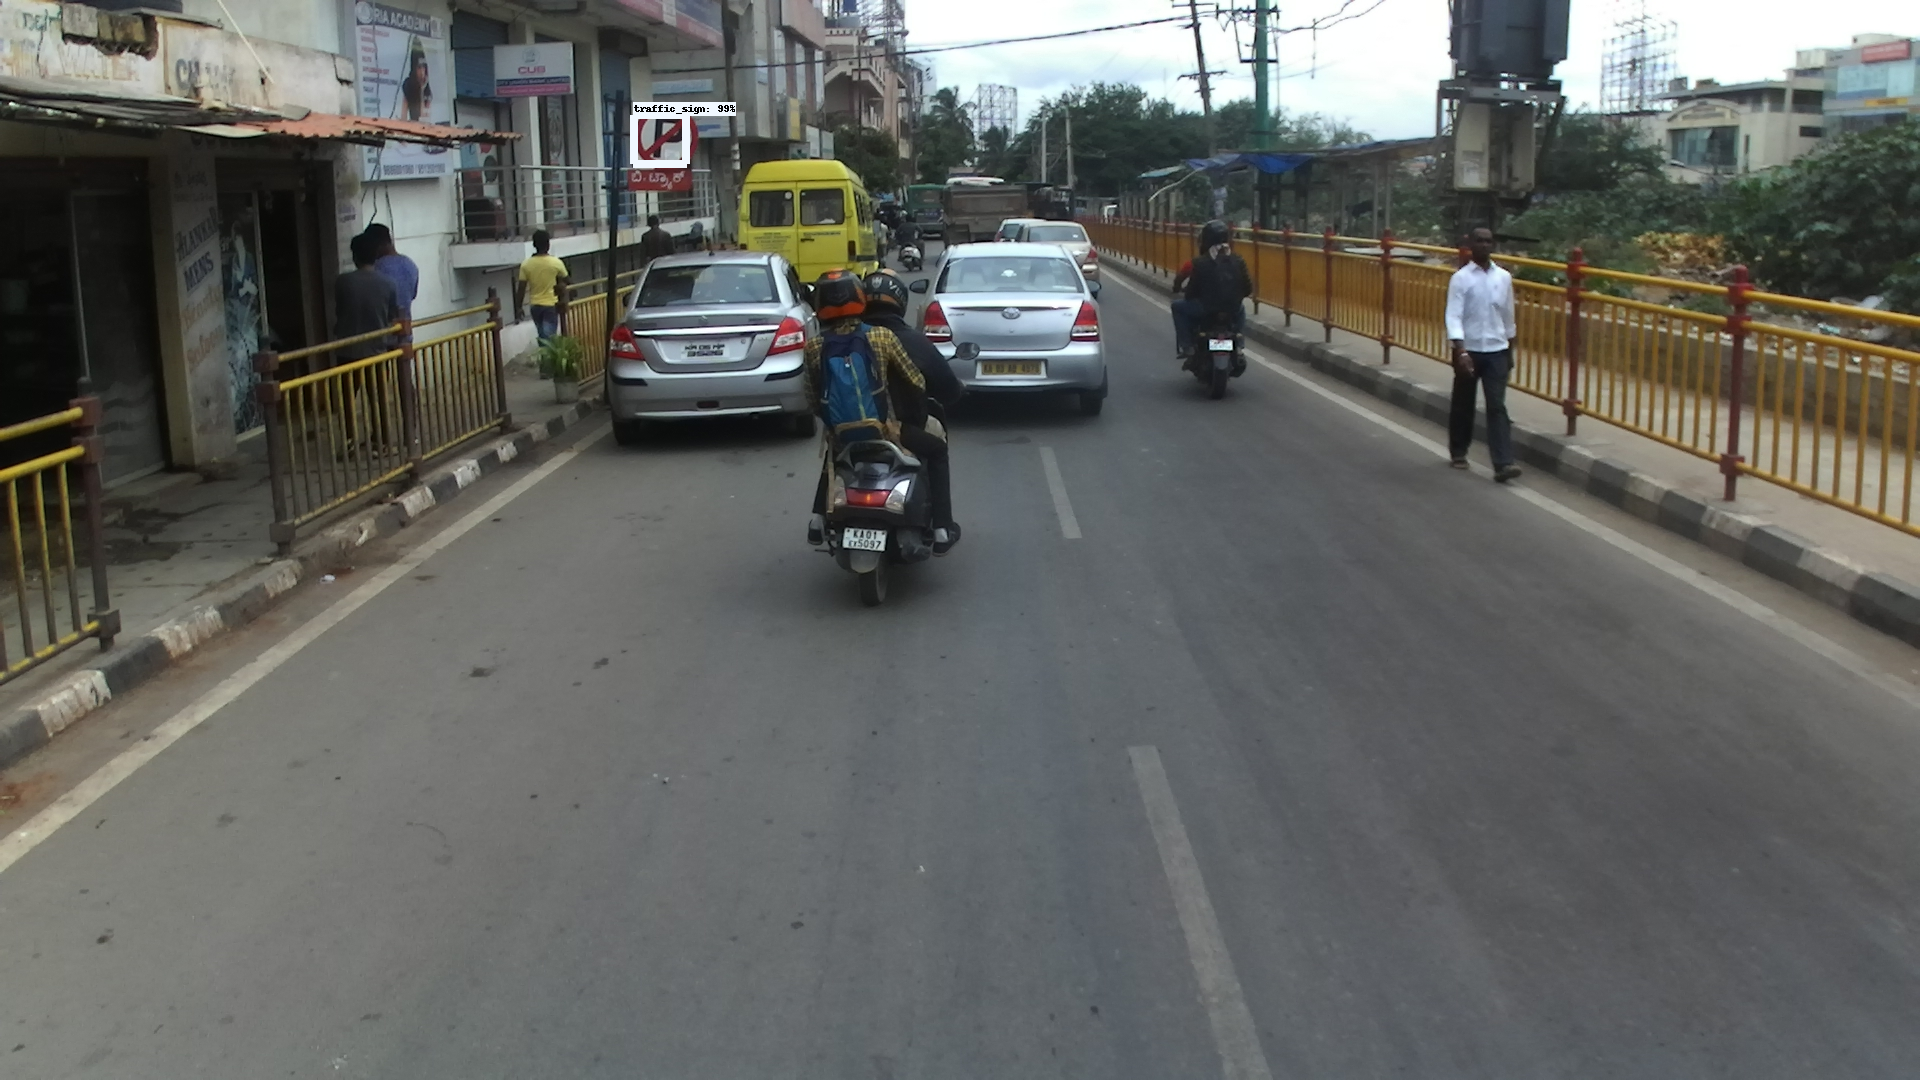

In [53]:
for image_path in TEST_IMAGE_PATHS:
    print(image_path)
    show_inference(interpreter, str(image_path))
    ## Press any key to continue to next image, or press 'q' to quit
    if cv2.waitKey(0) == ord('q'):
        break


In [54]:
## Clean up
cv2.destroyAllWindows()